Script implements a few decision boundary visualization methods for the CNNs trained on adversarial examples in this project. GitHub repos for relevant studies:

- https://github.com/mespadoto/sdbm (uses https://github.com/mespadoto/ssnp)
- https://github.com/sunblaze-ucb/decision-boundaries
- https://github.com/umd-huang-lab/Dynamics-Aware-Robust-Training
- https://github.com/gaurav-kaushik/Data-Visualizations-Medium
- https://github.com/MapperInteractive/MapperInteractive/tree/MIAT

In [1]:
# Importing necessary packages, and classes adapted from decision boundary visualization studies

import matplotlib.cm as cm
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2hsv, hsv2rgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.extmath import cartesian
import tensorflow as tf
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

import Models
from ssnp import SSNP

In [2]:
# function to save visualizations as png files
# adapted from https://github.com/mespadoto/sdbm

def results_to_png(np_matrix, prob_matrix, grid_size, n_classes,
        dataset_name, classifier_name, output_dir, real_points=None,
        max_value_hsv=None,
        suffix=None):

    if suffix is not None:
        suffix = f"_{suffix}"
    else:
        suffix = ""
    data = cm.tab20(np_matrix/n_classes)
    data_vanilla = data[:,:,:3].copy()

    if max_value_hsv is not None:
        data_vanilla = rgb2hsv(data_vanilla)
        data_vanilla[:, :, 2] = max_value_hsv
        data_vanilla = hsv2rgb(data_vanilla)
    
    if real_points is not None:
        data_vanilla = rgb2hsv(data_vanilla)
        data_vanilla[real_points[:, 0], real_points[:, 1], 2] = 1
        data_vanilla = hsv2rgb(data_vanilla)
    
    data_alpha = data.copy()

    data_hsv = data[:,:,:3].copy()
    data_alpha[:,:,3] = prob_matrix

    data_hsv = rgb2hsv(data_hsv)
    data_hsv[:,:,2] = prob_matrix
    data_hsv = hsv2rgb(data_hsv)

    rescaled_vanilla = (data_vanilla*255.0).astype(np.uint8)
    im_vanilla = Image.fromarray(rescaled_vanilla)
    print(f"Saving vanilla. {grid_size}x{grid_size} - {dataset_name} - {classifier_name}")
    im_vanilla.save(os.path.join(output_dir,f"{classifier_name}_{grid_size}x{grid_size}_{dataset_name}_vanilla{suffix}.png"))

    rescaled_alpha = (255.0*data_alpha).astype(np.uint8)
    im_alpha = Image.fromarray(rescaled_alpha)
    print(f"Saving alpha. {grid_size}x{grid_size} - {dataset_name} - {classifier_name}")
    im_alpha.save(os.path.join(output_dir,f"{classifier_name}_{grid_size}x{grid_size}_{dataset_name}_alpha{suffix}.png"))

    rescaled_hsv = (255.0*data_hsv).astype(np.uint8)
    im_hsv = Image.fromarray(rescaled_hsv)
    print(f"Saving hsv. {grid_size}x{grid_size} - {dataset_name} - {classifier_name}")
    im_hsv.save(os.path.join(output_dir,f"{classifier_name}_{grid_size}x{grid_size}_{dataset_name}_hsv{suffix}.png"))

    # Add a legend for the colors and labels
    legend_elements = [
        Patch(facecolor=cm.tab20(i / n_classes)[:3], label=f"{i}")
        for i in range(n_classes)
    ]

    # Create a figure for the legend
    plt.figure(figsize=(6, 1))
    plt.legend(handles=legend_elements, loc='center', ncol=n_classes, frameon=False)
    plt.axis('off')
    plt.title("Legend")
    plt.tight_layout()
    plt.show()
    
    return im_vanilla, im_alpha, im_hsv


In [3]:
# Importing MNIST dataset from ../data folder
data_dir = os.path.abspath(os.path.join(os.getcwd(), "../data"))
MNIST_data = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())

# Splitting into X and Y:
x = MNIST_data.data.numpy()
y = MNIST_data.targets.numpy()

x_flattened = x.reshape(x.shape[0], -1)
image_shape = x.shape[1:]
image_channels = 1 if len(image_shape) == 2 else image_shape[0]

scaler = MinMaxScaler()
scaler.fit(x_flattened)
normalized_x = scaler.transform(x_flattened)
normalized_x = normalized_x.astype('float32')

# Defining output directory for visualizations
output_dir = os.path.abspath(os.path.join(os.getcwd(), "../output/images"))

In [4]:
#print(image_shape)
#print(image_channels)

#plt.imshow(x[0], cmap='gray')

In [5]:
# Importing the classification model
model_name = "small_conv_vanilla"
model_dir = os.path.abspath(os.path.join(os.getcwd(), "../models", model_name + ".pth"))

MNIST_classifier = Models.SmallConvNet()
MNIST_classifier.load_state_dict(torch.load(model_dir))
device_torch = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else 
                      "cpu")
MNIST_classifier.to(device_torch)
MNIST_classifier.eval()

SmallConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=49, bias=True)
  (fc2): Linear(in_features=49, out_features=10, bias=True)
)

In [23]:
# Create and train the SSNP model
patience = 10
epochs = 50
verbose = True

# Choose device
if tf.config.list_physical_devices('GPU'):
    device_tf = '/GPU:0'  # Use GPU if available
elif tf.config.list_physical_devices('MPS'):
    device_tf = '/MPS:0'  # Use MPS (Metal Performance Shaders) if available
else:
    device_tf = '/CPU:0'  # Default to CPU

with tf.device(device_tf):
    ssnpgt = SSNP(epochs=epochs, 
                   verbose=verbose, 
                   patience=patience, 
                   opt='adam', 
                   bottleneck_activation='linear'
                   )
    ssnpgt.fit(normalized_x, y)


Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - decoder_output_loss: 0.3695 - decoder_output_mse: 0.1029 - loss: 2.9138 - main_output_accuracy: 0.4120 - main_output_loss: 1.4554 - val_decoder_output_loss: 0.2399 - val_decoder_output_mse: 0.0581 - val_loss: 1.1716 - val_main_output_accuracy: 0.7880 - val_main_output_loss: 0.6952
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - decoder_output_loss: 0.2280 - decoder_output_mse: 0.0550 - loss: 0.8870 - main_output_accuracy: 0.8440 - main_output_loss: 0.4881 - val_decoder_output_loss: 0.2286 - val_decoder_output_mse: 0.0548 - val_loss: 0.8234 - val_main_output_accuracy: 0.8360 - val_main_output_loss: 0.5195
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - decoder_output_loss: 0.2196 - decoder_output_mse: 0.0527 - loss: 0.5551 - main_output_accuracy: 0.9213 - main_output_loss: 0.2714 - val_decoder_output_loss: 0.2256 - val_decoder_output_mse: 0.0543 - val_loss: 0.7814 - val_main_output_accuracy: 0.8640 - val_main_output_lo

In [16]:
# Save the SSNP model

save_model = True
save_dir = os.path.abspath(os.path.join(os.getcwd(), "../models"))
ssnp_name = "ssnp_mnist"
ssnp_dir = os.path.join(save_dir, ssnp_name + ".keras")

if save_model:
    ssnpgt.save_model(ssnp_dir)

In [17]:
# Load the SSNP model
load_model = True
if load_model:
    ssnpgt = SSNP(epochs=epochs, 
                   verbose=verbose, 
                   patience=patience, 
                   opt='adam', 
                   bottleneck_activation='linear'
                   )
    ssnpgt.load_model(ssnp_dir)    

In [13]:
# Create grid
grid_size = 300

# Project training x data into the 2D space
x_ssnpgt = ssnpgt.transform(normalized_x)

scaler = MinMaxScaler()
scaler.fit(x_ssnpgt)
xmin = np.min(x_ssnpgt[:, 0])
xmax = np.max(x_ssnpgt[:, 0])
ymin = np.min(x_ssnpgt[:, 1])
ymax = np.max(x_ssnpgt[:, 1])

img_grid = np.zeros((grid_size,grid_size))
prob_grid = np.zeros((grid_size,grid_size))

x_intrvls = np.linspace(xmin, xmax, num=grid_size)
y_intrvls = np.linspace(ymin, ymax, num=grid_size)

x_grid = np.linspace(0, grid_size-1, num=grid_size)
y_grid = np.linspace(0, grid_size-1, num=grid_size)

pts = cartesian((x_intrvls, y_intrvls))
pts_grid = cartesian((x_grid, y_grid))
pts_grid = pts_grid.astype(int)

# Normalize the real data points to fit the grid
scaler = MinMaxScaler()
scaler.fit(x_ssnpgt)
normalized_x_ssnpgt = scaler.transform(x_ssnpgt)
normalized_x_ssnpgt = normalized_x_ssnpgt.astype('float32')

normalized_x_ssnpgt *= (grid_size-1)
normalized_x_ssnpgt = normalized_x_ssnpgt.astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [19]:
# Produce the grid of points in the 2D space

clf_name, clf = model_name, MNIST_classifier
d = 'MNIST'
dataset_name = 'mnist'
n_samples = MNIST_data.data.shape[0]
n_classes = 10

# Processing limited number of grid points due to memory constraints
batch_size = 100000
position = 0
while position < len(pts):
    # Extract batch of points from the grid
    pts_batch = pts[position:position+batch_size]

    # Transform the points from 2D to original image space using inverse SSNP
    with tf.device(device_tf):
        image_batch = ssnpgt.inverse_transform(pts_batch)

    # Predict the labels for synthetic points using the classifier
    clf.eval()
    with torch.no_grad():
        # Unflatten the image to original shape
        image_batch_tensor = torch.tensor(image_batch, dtype=torch.float32)
        image_batch_tensor = image_batch_tensor.to(device_torch)
        image_batch_tensor = image_batch_tensor.view(image_batch_tensor.shape[0], image_channels, image_shape[0], image_shape[1])
        image_batch_tensor = image_batch_tensor.to(device_torch)
        
        logits = clf(image_batch_tensor)
        probs = F.softmax(logits, dim=1)
        labels = torch.argmax(probs, dim=1).cpu().numpy()
        alpha = torch.amax(probs, dim=1).cpu().numpy()
    
    pts_grid_batch = pts_grid[position:position+batch_size]

    img_grid[
        pts_grid_batch[:, 0],
        pts_grid_batch[:, 1]
        ] = labels

    position += batch_size

    prob_grid[
        pts_grid_batch[:, 0],
        pts_grid_batch[:, 1]
        ] = alpha


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


Saving vanilla. 300x300 - mnist - small_conv_vanilla
Saving alpha. 300x300 - mnist - small_conv_vanilla
Saving hsv. 300x300 - mnist - small_conv_vanilla


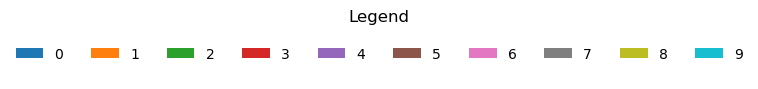

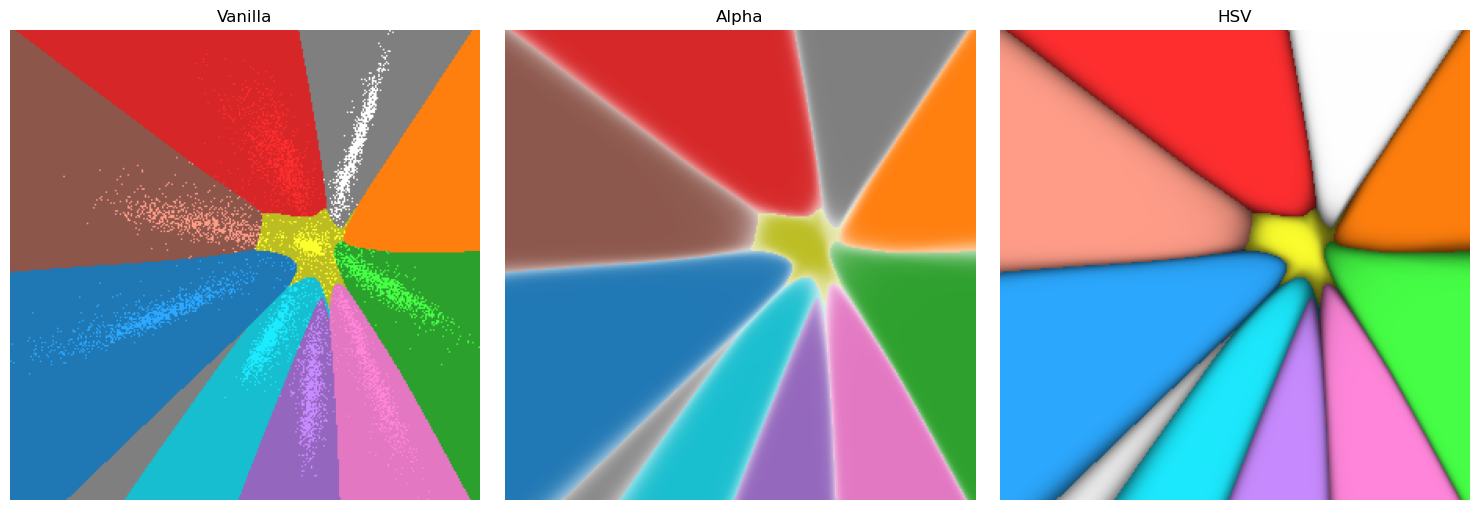

In [20]:
# Generate image from the predictions
im_vanilla, im_alpha, im_hsv = results_to_png(
    np_matrix=img_grid,
    prob_matrix=prob_grid,
    grid_size=grid_size,
    dataset_name=dataset_name,
    classifier_name=clf_name,
    output_dir=output_dir,
    real_points=normalized_x_ssnpgt,
    n_classes=n_classes)

# Display the images in a row with labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create 1 row and 3 columns of subplots

# Titles for the images
titles = ["Vanilla", "Alpha", "HSV"]

# Images to display
images = [im_vanilla, im_alpha, im_hsv]

# Loop through the images and axes
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)  # Display the image
    ax.set_title(title)  # Set the title
    ax.axis('off')  # Turn off the axis

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

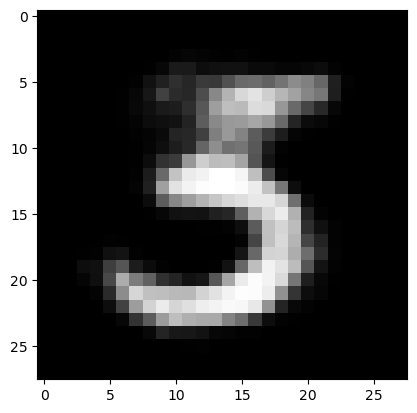

In [21]:
#print(image_batch_tensor.shape)
#print(image_batch_tensor[0].shape)
#print(x_ssnpgt.shape)

plt.imshow(image_batch_tensor[0].squeeze().cpu(), cmap='gray')